In [145]:
#### import the required packages
import re
import os
import nltk
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from wordcloud import WordCloud

from tensorflow.keras import preprocessing
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN

## 1. Text Data Preprocessing

### 1.1 Load the Text Data

In [2]:
#Reading the given csv file using pandas
dat = pd.read_csv('bbc-text.csv')

In [3]:
dat.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [5]:
dat.shape

(2225, 2)

In [6]:
dat['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [7]:
#To check if there is any missing data
print('Number of nulls in category: {}'.format(dat['category'].isnull().sum()))
print('Number of nulls in text: {}'.format(dat['text'].isnull().sum()))

Number of nulls in category: 0
Number of nulls in text: 0


### 1.2 Cleanse the Text Data

In [8]:
#Checking the data
dat['text'][0]

'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [9]:
#Cleansing of punctuation, special characters, digits and lowercase characters
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W|_)+"," ",text)
    
    return text

#Creating a new column called 'text_nopunct'
dat['text_nopunct'] = dat['text'].apply(lambda x:pre_process(x)) 
dat.head()

,category,text,text_nopunct
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...


In [10]:
#Define a function to split our sentences into a list of words aka Tokenization
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

dat['text_tokenized'] = dat['text_nopunct'].apply(lambda x: tokenize(x.lower()))

dat.head()

,category,text,text_nopunct,text_tokenized
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with..."
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...,"[tigers, wary, of, farrell, gamble, leicester,..."
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ..."


In [11]:
def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
#load a set of stop words
stopwords=get_stop_words("stopwords.txt")

def remove_stopwords(tokenized_text):    
    text = [word for word in tokenized_text if word not in stopwords]
    return text

dat['text_nostop'] = dat['text_tokenized'].apply(lambda x: remove_stopwords(x))
dat.head()

,category,text,text_nopunct,text_tokenized,text_nostop
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy..."
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, former, worldcom..."
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, rus..."
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, newcastle, fa, cup, premiership, new..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe..."


In [12]:
def join_words(text_nostop):
    text = " ".join(text_nostop)
    return text

dat['cleansed_text'] = dat['text_nostop'].apply(lambda x: join_words(x))
dat.head()

,category,text,text_nopunct,text_tokenized,text_nostop,cleansed_text
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy...",tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, former, worldcom...",worldcom boss left books former worldcom boss ...
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, rus...",tigers wary farrell gamble leicester rushed bi...
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, newcastle, fa, cup, premiership, new...",yeading newcastle fa cup premiership newcastle...
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe...",ocean twelve raids box office ocean twelve cri...


In [13]:
cleansed_text = dat['cleansed_text']

In [14]:
cleansed_text.shape

(2225,)

In [15]:
cleansed_text.head()

0    tv future hands viewers home theatre systems p...
1    worldcom boss left books former worldcom boss ...
2    tigers wary farrell gamble leicester rushed bi...
3    yeading newcastle fa cup premiership newcastle...
4    ocean twelve raids box office ocean twelve cri...
Name: cleansed_text, dtype: object

### 1.3 Bag-of-Word

In [16]:
count_vect = CountVectorizer(max_df=0.15, max_features=5000)
text_counts = count_vect.fit_transform(cleansed_text)

In [17]:
text_counts.shape

(2225, 5000)

In [18]:
sum_words =text_counts.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [19]:
print('The highest frequency words:')
words_freq[0:20] 

The highest frequency words:


[('bn', 958),
 ('film', 890),
 ('music', 839),
 ('labour', 804),
 ('election', 662),
 ('party', 630),
 ('games', 622),
 ('england', 618),
 ('blair', 603),
 ('technology', 561),
 ('minister', 561),
 ('public', 557),
 ('mobile', 546),
 ('british', 542),
 ('tv', 525),
 ('european', 525),
 ('players', 524),
 ('sales', 494),
 ('plans', 486),
 ('six', 484)]

In [20]:
print('The lowest frequency words:') 
words_freq[-20:] 

The lowest frequency words:


[('gray', 13),
 ('fate', 13),
 ('ghosn', 13),
 ('renault', 13),
 ('petroleum', 13),
 ('collecting', 13),
 ('boards', 13),
 ('immense', 13),
 ('gay', 13),
 ('saulnier', 13),
 ('hundred', 13),
 ('credibility', 13),
 ('purposes', 13),
 ('elton', 13),
 ('mcmanus', 13),
 ('magnier', 13),
 ('inbev', 13),
 ('trackers', 13),
 ('csos', 13),
 ('legendary', 13)]

In [21]:
count_vect.get_feature_names()

['aaas',
 'abandoned',
 'abc',
 'ability',
 'able',
 'abn',
 'abortion',
 'abroad',
 'absence',
 'absolute',
 'absolutely',
 'abuse',
 'abused',
 'ac',
 'academy',
 'accept',
 'acceptable',
 'accepted',
 'access',
 'accessible',
 'accident',
 'acclaimed',
 'accompanied',
 'according',
 'account',
 'accounting',
 'accounts',
 'accurate',
 'accused',
 'accusing',
 'achieve',
 'achieved',
 'achievement',
 'achievements',
 'achieving',
 'acknowledged',
 'acquire',
 'acquisition',
 'act',
 'acting',
 'action',
 'actions',
 'active',
 'activist',
 'activists',
 'activities',
 'activity',
 'actor',
 'actors',
 'actress',
 'acts',
 'actually',
 'ad',
 'adam',
 'adams',
 'adapt',
 'adaptation',
 'adapted',
 'add',
 'adding',
 'addition',
 'additional',
 'address',
 'addresses',
 'adds',
 'adjusted',
 'administration',
 'admit',
 'admits',
 'admitted',
 'adopt',
 'adopted',
 'adoption',
 'ads',
 'adult',
 'adults',
 'advance',
 'advanced',
 'advantage',
 'adventure',
 'advertising',
 'adverts',


In [22]:
feature_names=np.array(count_vect.get_feature_names())
len(count_vect.get_feature_names())

5000

In [23]:
pd.DataFrame(text_counts.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 1.4 TF-IDF

In [24]:
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
text_tfidf = tfidf_transformer.fit_transform(text_counts)

In [25]:
tfidf_transformer.idf_

array([6.62851999, 5.81758977, 6.22305488, ..., 5.87474819, 5.81758977,
       5.99991133])

In [26]:
tfidf_transformer.idf_.shape

(5000,)

In [27]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['six' 'according' 'public' 'month' 'day' 'bn' 'based' 'called' 'british'
 'minister' 'move' 'hit' 'international' 'don' 'director' 'help' 'despite'
 'london' 'half' 'plans' 'record' 'european' 'start' 'money' 'seen' 're'
 'players' 'spokesman' 'future' 'business' 'earlier' 'companies' 'britain'
 'run' 'able' 'saying' 'europe' 'biggest' 'times' 'due' 'taking' 'lost'
 'decision' 'team' 'national' 'recent' 'industry' 'england' 'deal' 'past'
 'film' 'life' 'service' 'found' 'final' 'lot' 'labour' 'january'
 'technology' 'music' 'days' 'executive' 'looking' 'look' 'following'
 'games' 'action' 'strong' 'major' 'growth' 'using' 'ahead' 'real'
 'believe' 'michael' 'line' 'currently' 'party' 'hard' 'little'
 'president' 'playing' 'december' 'held' 'election' 'services' 'played'
 'system' 'office' 'current' 'david' 'figures' 'left' 'firms' 've'
 'include' 'announced' 'john' 'cut' 'analysts']


In [28]:
pd.DataFrame(text_tfidf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.091391,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
max_value = text_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['savvy' 'specifications' 'sadly' 'types' 'constantly' 'etc' 'status'
 'amongst' 'crimes' 'kinds' 'instant' 'changing' 'finnish' 'maintaining'
 'reaching' 'credibility' 'purpose' 'occasion' 'informed' 'katerina']
Features with highest tfidf: 
['cairn' 'stern' 'brando' 'wmc' 'viacom' 'mitsubishi' 'copper' 'edwards'
 'beer' 'boeing' 'qantas' 'mirza' 'fiat' 'mtv' 'mutu' 'dallaglio' 'uwb'
 'ink' 'commodore' 'ballet']


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [30]:
idx = 997
doc = cleansed_text[idx]
print(doc)

tf_idf_vector = text_tfidf[idx]
print(tf_idf_vector)

rap boss arrested drug rap mogul marion suge knight arrested violating parole allegedly found marijuana arrested barstow california saturday following alleged traffic offence expected transferred prison decision released knight founder death row records served month jail term punching parole assault conviction police knight stopped saturday performing illegal search car allegedly found marijuana accused insurance woman car arrested providing false information fake id card released alleged violation previously served half nine sentence breaking terms parole knight jailed october following involvement fight rival gang hours rapper tupac shakur killed las vegas drive shooting driving shakur car time shot head time probation assaulting musicians knight former bodyguard set death row records shakur dr dre protegees label dogged allegations supports gang culture fuels east west coast rap rivalry 
  (0, 4943)	0.07312173177185453
  (0, 4900)	0.06652033979755682
  (0, 4767)	0.08520097476610562


In [31]:
tf_idf_vector.shape

(1, 5000)

In [32]:
temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
temp

,feature_number,tf_idf
0,4943,0.073122
1,4900,0.066520
2,4767,0.085201
3,4621,0.077681
4,4518,0.064102
...,...,...
67,257,0.332338
68,144,0.176637
69,143,0.150176
70,142,0.078037


In [33]:
temp.sort_values('tf_idf', ascending = False, inplace = True)
temp

,feature_number,tf_idf
34,2504,0.500045
67,257,0.332338
20,3578,0.274040
62,643,0.207504
68,144,0.176637
...,...,...
40,2280,0.055976
44,2072,0.055798
57,1164,0.050567
45,2031,0.047934


In [34]:
topn =5   
topn_items = temp[:topn]

tf_idf = []
word = []

for index, row in topn_items.iterrows():
    fname = feature_names[int(row['feature_number'])]
    #word eg zombie
    word.append(fname)
    #tf_idf eg 0.215
    tf_idf.append(round(row['tf_idf'], 3))    

In [35]:
print(doc, '\n')

result = dict(zip(word, tf_idf))
print(result)


rap boss arrested drug rap mogul marion suge knight arrested violating parole allegedly found marijuana arrested barstow california saturday following alleged traffic offence expected transferred prison decision released knight founder death row records served month jail term punching parole assault conviction police knight stopped saturday performing illegal search car allegedly found marijuana accused insurance woman car arrested providing false information fake id card released alleged violation previously served half nine sentence breaking terms parole knight jailed october following involvement fight rival gang hours rapper tupac shakur killed las vegas drive shooting driving shakur car time shot head time probation assaulting musicians knight former bodyguard set death row records shakur dr dre protegees label dogged allegations supports gang culture fuels east west coast rap rivalry  

{'knight': 0.5, 'arrested': 0.332, 'rap': 0.274, 'car': 0.208, 'allegedly': 0.177}


In [36]:
results =[]

In [37]:
for idx, doc in cleansed_text.items():
    #generate tf-idf for the given document
    tf_idf_vector=text_tfidf[idx]
    
    temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
    temp.sort_values('tf_idf', ascending = False, inplace = True)
    
    #use only topn items from vector
     
    topn_items = temp[:topn]

    tf_idf = []
    word = []

    for index, row in topn_items.iterrows():
        #print(int(row['feature_number']))
        fname = feature_names[int(row['feature_number'])]
        word.append(fname)
        tf_idf.append(round(row['tf_idf'], 3))

    result = dict(zip(word, tf_idf))
    
    results.append(result)

In [38]:
print(len(results))
results

2225


[{'tv': 0.425,
  'definition': 0.193,
  'watch': 0.17,
  'satellite': 0.167,
  'content': 0.159},
 {'worldcom': 0.534,
  'ebbers': 0.49,
  'accounting': 0.304,
  'fraud': 0.156,
  'defence': 0.143},
 {'farrell': 0.576,
  'leicester': 0.261,
  'tigers': 0.235,
  'rugby': 0.231,
  'league': 0.213},
 {'league': 0.236,
  'west': 0.197,
  'cup': 0.174,
  'united': 0.169,
  'drawn': 0.167},
 {'ocean': 0.469,
  'sequel': 0.408,
  'twelve': 0.285,
  'starring': 0.212,
  'box': 0.19},
 {'howard': 0.546,
  'party': 0.239,
  'labour': 0.201,
  'election': 0.172,
  'michael': 0.17},
 {'parliament': 0.377,
  'election': 0.362,
  'blair': 0.319,
  'april': 0.22,
  'name': 0.207},
 {'henman': 0.619,
  'rain': 0.325,
  'seed': 0.259,
  'ljubicic': 0.22,
  'frustrating': 0.211},
 {'wilkinson': 0.506,
  'injury': 0.255,
  'edinburgh': 0.228,
  'england': 0.214,
  'newcastle': 0.208},
 {'wars': 0.445,
  'lucas': 0.378,
  'rating': 0.347,
  'film': 0.316,
  'star': 0.267},
 {'film': 0.5,
  'nazi': 0.291,


In [39]:
dat['keywords'] = results
dat.head()

,category,text,text_nopunct,text_tokenized,text_nostop,cleansed_text,keywords
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy...",tv future hands viewers home theatre systems p...,"{'tv': 0.425, 'definition': 0.193, 'watch': 0...."
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, former, worldcom...",worldcom boss left books former worldcom boss ...,"{'worldcom': 0.534, 'ebbers': 0.49, 'accountin..."
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, rus...",tigers wary farrell gamble leicester rushed bi...,"{'farrell': 0.576, 'leicester': 0.261, 'tigers..."
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, newcastle, fa, cup, premiership, new...",yeading newcastle fa cup premiership newcastle...,"{'league': 0.236, 'west': 0.197, 'cup': 0.174,..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe...",ocean twelve raids box office ocean twelve cri...,"{'ocean': 0.469, 'sequel': 0.408, 'twelve': 0...."


In [40]:
dat.to_csv('bbc_export.csv')

In [41]:
keyw =  dat.iloc[:,[6]]
keyw

,keywords
0,"{'tv': 0.425, 'definition': 0.193, 'watch': 0...."
1,"{'worldcom': 0.534, 'ebbers': 0.49, 'accountin..."
2,"{'farrell': 0.576, 'leicester': 0.261, 'tigers..."
3,"{'league': 0.236, 'west': 0.197, 'cup': 0.174,..."
4,"{'ocean': 0.469, 'sequel': 0.408, 'twelve': 0...."
...,...
2220,"{'sales': 0.587, 'retail': 0.337, 'stores': 0...."
2221,"{'kilroy': 0.446, 'asylum': 0.393, 'silk': 0.3..."
2222,"{'glasgow': 0.47, 'concert': 0.408, 'gig': 0.3..."
2223,"{'prisoners': 0.453, 'arms': 0.418, 'argument'..."


In [42]:
keyw.to_csv('keywords_export.csv')

### 2.2 Association Rules Mining on keywords

In [43]:
df = pd.read_csv('keywords_export.csv', header = None)
df.shape

(2226, 2)

In [44]:
df.head()

,0,1
0,NaN,keywords
1,0.0,"{'tv': 0.425, 'definition': 0.193, 'watch': 0...."
2,1.0,"{'worldcom': 0.534, 'ebbers': 0.49, 'accountin..."
3,2.0,"{'farrell': 0.576, 'leicester': 0.261, 'tigers..."
4,3.0,"{'league': 0.236, 'west': 0.197, 'cup': 0.174,..."


In [45]:
df.describe()

,0
count,2225.000000
mean,1112.000000
std,642.446496
min,0.000000
25%,556.000000
50%,1112.000000
75%,1668.000000
max,2224.000000


In [46]:
df = df.iloc[: , 1:]

In [47]:
df.head()

,1
0,keywords
1,"{'tv': 0.425, 'definition': 0.193, 'watch': 0...."
2,"{'worldcom': 0.534, 'ebbers': 0.49, 'accountin..."
3,"{'farrell': 0.576, 'leicester': 0.261, 'tigers..."
4,"{'league': 0.236, 'west': 0.197, 'cup': 0.174,..."


In [48]:
def pre_process(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("</?.*?>"," <> ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W|_)+"," ",text)
    
    return text

df['keywords'] = df[1].apply(lambda x:pre_process(x)) 
df.head()

,1,keywords
0,keywords,keywords
1,"{'tv': 0.425, 'definition': 0.193, 'watch': 0....",tv definition watch satellite content
2,"{'worldcom': 0.534, 'ebbers': 0.49, 'accountin...",worldcom ebbers accounting fraud defence
3,"{'farrell': 0.576, 'leicester': 0.261, 'tigers...",farrell leicester tigers rugby league
4,"{'league': 0.236, 'west': 0.197, 'cup': 0.174,...",league west cup united drawn


In [49]:
df = df.iloc[: , 1:]

In [50]:
df.head()

,keywords
0,keywords
1,tv definition watch satellite content
2,worldcom ebbers accounting fraud defence
3,farrell leicester tigers rugby league
4,league west cup united drawn


In [51]:
df = df.join(df['keywords'].str.split(' ',expand=True))

In [52]:
df = df.iloc[: , 2:]

In [53]:
df.head()

,1,2,3,4,5,6
0,None,None,None,None,None,None
1,tv,definition,watch,satellite,content,
2,worldcom,ebbers,accounting,fraud,defence,
3,farrell,leicester,tigers,rugby,league,
4,league,west,cup,united,drawn,


In [54]:
df = df.iloc[: , :-1]

In [55]:
df = df.iloc[1: , :]

In [56]:
df.head()

,1,2,3,4,5
1,tv,definition,watch,satellite,content
2,worldcom,ebbers,accounting,fraud,defence
3,farrell,leicester,tigers,rugby,league
4,league,west,cup,united,drawn
5,ocean,sequel,twelve,starring,box


In [57]:
df.describe()

,1,2,3,4,5
count,2225,2225,2225,2225,2225
unique,1116,1189,1284,1308,1339
top,film,labour,labour,film,bn
freq,20,20,19,29,16


In [58]:
df.shape

(2225, 5)

In [59]:
full_list=pd.Series([])
for col in df:
    full_list = full_list.append(df[col].dropna())

C:\Users\Brayden\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [60]:
print(full_list)

1             tv
2       worldcom
3        farrell
4         league
5          ocean
          ...   
2221        rose
2222     britain
2223        june
2224        word
2225      graeme
Length: 11125, dtype: object


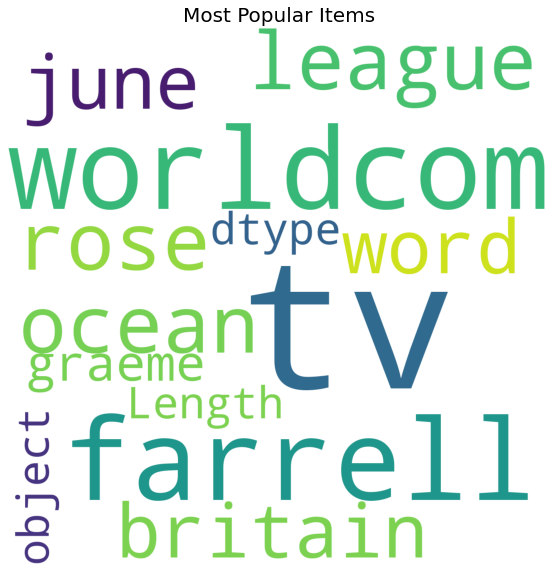

In [61]:
plt.rcParams['figure.figsize'] = (10, 10)
wordcloud = WordCloud(background_color = 'white', width = 1200,  height = 1200, max_words = 121).generate(str(full_list))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Most Popular Items',fontsize = 20)
plt.show()

In [62]:
full_list.value_counts()

film             87
labour           59
bn               57
blair            57
brown            51
                 ..
searching         1
earn              1
save              1
parliamentary     1
uncertain         1
Length: 3067, dtype: int64

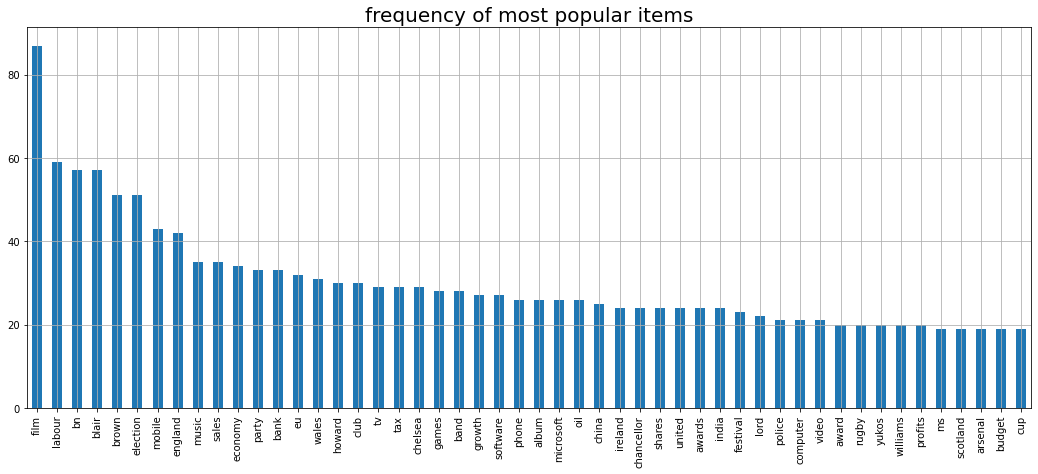

In [63]:
plt.figure(figsize=(18,7))
full_list.value_counts().head(50).plot.bar()
plt.title('frequency of most popular items', fontsize = 20)
plt.xticks(rotation = 90 )
plt.grid()
plt.show()

In [64]:
#y = full_list.value_counts().head(50).to_frame()
#y.index

In [65]:
# making each keyword_list into an identical list
trans = []
for i in range(0, 2225):
    trans.append([str(df.values[i,j]) for j in range(0, 5)])

# conveting it into an numpy array
trans = np.array(trans)

# checking the shape of the array
print(trans.shape)

(2225, 5)


In [66]:
print(trans)

[['tv' 'definition' 'watch' 'satellite' 'content']
 ['worldcom' 'ebbers' 'accounting' 'fraud' 'defence']
 ['farrell' 'leicester' 'tigers' 'rugby' 'league']
 ...
 ['glasgow' 'concert' 'gig' 'tickets' 'june']
 ['prisoners' 'arms' 'argument' 'incentives' 'word']
 ['souness' 'goal' 'uefa' 'cup' 'graeme']]


In [67]:
#Transforms the input dataset (a Python list of lists) into a one-hot encoded NumPy boolean array
te = TransactionEncoder()
data_encoded = te.fit_transform(trans)
data_encoded = pd.DataFrame(data_encoded, columns = te.columns_)
data_encoded.shape

(2225, 3067)

In [68]:
data_encoded

,aaas,abandoned,abc,abn,abortion,ac,academy,accept,access,accident,...,yes,yorkshire,youth,yuan,yugansk,yuganskneftegas,yukos,yushchenko,zealand,zero
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2221,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2222,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2223,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [69]:
#First, let us return the items and itemsets with at least 0.1% support:
frequent_itemsets=apriori(data_encoded, min_support = 0.001, use_colnames = True)

In [70]:
frequent_itemsets

,support,itemsets
0,0.001798,(abc)
1,0.002247,(academy)
2,0.003146,(access)
3,0.001348,(accounting)
4,0.002247,(act)
...,...,...
2295,0.001348,"(veritas, ukip, silk, party)"
2296,0.001348,"(unions, pension, prescott, workers)"
2297,0.001348,"(microsoft, explorer, firefox, ie, browser)"
2298,0.001348,"(pension, choice, unions, prescott, workers)"


In [71]:
frequent_itemsets[['support']].describe()

,support
count,2300.000000
mean,0.002434
std,0.002255
min,0.001348
25%,0.001348
50%,0.001798
75%,0.002697
max,0.039101


<b>Using Confidence Threshold</b>

In [72]:
rules_c = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)
rules_c

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(academy),(awards),0.002247,0.010787,0.001348,0.600000,55.625000,0.001324,2.473034
1,(access),(bt),0.003146,0.006292,0.001348,0.428571,68.112245,0.001329,1.738989
2,(access),(digital),0.003146,0.007640,0.001348,0.428571,56.092437,0.001324,1.736629
3,(divide),(access),0.001348,0.003146,0.001348,1.000000,317.857143,0.001344,inf
4,(access),(divide),0.003146,0.001348,0.001348,0.428571,317.857143,0.001344,1.747640
...,...,...,...,...,...,...,...,...,...
2300,"(veritas, party)","(ukip, kilroy, silk)",0.001798,0.002697,0.001348,0.750000,278.125000,0.001343,3.989213
2301,"(ukip, party)","(veritas, kilroy, silk)",0.002697,0.001798,0.001348,0.500000,278.125000,0.001343,1.996404
2302,(kilroy),"(veritas, ukip, silk, party)",0.004045,0.001348,0.001348,0.333333,247.222222,0.001343,1.497978
2303,(silk),"(veritas, ukip, kilroy, party)",0.003596,0.001348,0.001348,0.375000,278.125000,0.001343,1.597843


In [73]:
rules_c.sort_values('confidence', ascending = False, inplace = True)
rules_c.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1402,"(ms, simonetti)",(delta),0.001348,0.002247,0.001348,1.0,445.000000,0.001345,inf
1953,"(browser, firefox)","(microsoft, explorer)",0.001348,0.001798,0.001348,1.0,556.250000,0.001346,inf
1813,"(airline, ms, simonetti)",(delta),0.001348,0.002247,0.001348,1.0,445.000000,0.001345,inf
1812,"(delta, airline, ms)",(simonetti),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
589,(handsets),(mobile),0.001798,0.019326,0.001798,1.0,51.744186,0.001763,inf
1089,"(bill, cards)",(id),0.001348,0.003596,0.001348,1.0,278.125000,0.001343,inf
1810,(divide),"(digital, access, report)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
592,(potter),(harry),0.001348,0.002697,0.001348,1.0,370.833333,0.001345,inf
1809,"(access, report)","(digital, divide)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
594,(hdtv),(tv),0.001348,0.013034,0.001348,1.0,76.724138,0.001331,inf


<AxesSubplot:>

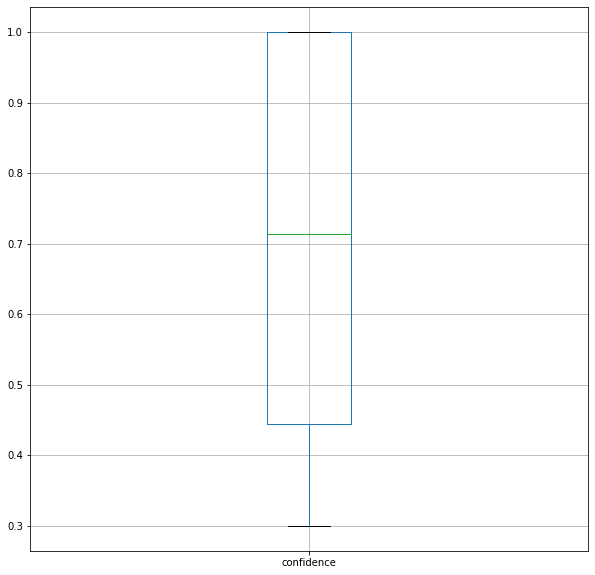

In [74]:
rules_c[['confidence']].boxplot()

<b>Using Lift Threshold</b>

In [75]:
rules_l = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_l

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(academy),(awards),0.002247,0.010787,0.001348,0.600000,55.625000,0.001324,2.473034
1,(awards),(academy),0.010787,0.002247,0.001348,0.125000,55.625000,0.001324,1.140289
2,(bt),(access),0.006292,0.003146,0.001348,0.214286,68.112245,0.001329,1.268723
3,(access),(bt),0.003146,0.006292,0.001348,0.428571,68.112245,0.001329,1.738989
4,(digital),(access),0.007640,0.003146,0.001348,0.176471,56.092437,0.001324,1.210465
...,...,...,...,...,...,...,...,...,...
3229,(kilroy),"(veritas, ukip, silk, party)",0.004045,0.001348,0.001348,0.333333,247.222222,0.001343,1.497978
3230,(silk),"(veritas, ukip, kilroy, party)",0.003596,0.001348,0.001348,0.375000,278.125000,0.001343,1.597843
3231,(veritas),"(ukip, kilroy, silk, party)",0.002247,0.001798,0.001348,0.600000,333.750000,0.001344,2.495506
3232,(ukip),"(veritas, kilroy, silk, party)",0.005393,0.001348,0.001348,0.250000,185.416667,0.001341,1.331536


In [76]:
rules_l.sort_values('lift', ascending = False, inplace = True)
rules_l.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2844,"(browser, firefox)","(ie, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1948,"(ie, browser)",(firefox),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3172,(ie),"(browser, microsoft, explorer, firefox)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3171,(firefox),"(ie, browser, microsoft, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3168,"(ie, browser)","(microsoft, explorer, firefox)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3167,"(browser, firefox)","(ie, microsoft, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3166,"(ie, firefox)","(browser, microsoft, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3165,"(browser, explorer)","(ie, microsoft, firefox)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3164,"(ie, explorer)","(browser, microsoft, firefox)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3163,"(explorer, firefox)","(ie, browser, microsoft)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf


<AxesSubplot:>

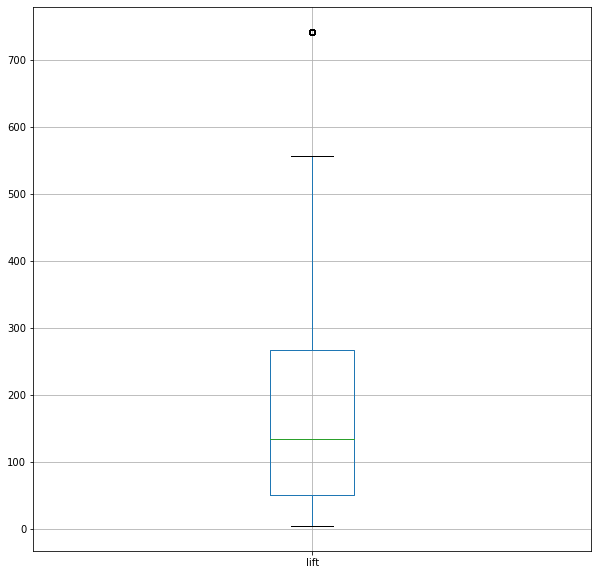

In [77]:
rules_l[['lift']].boxplot()

<b>Using both Confidence and Lift Thresholds</b>

In [164]:
# Using Confidence
# Using Lift
rules_c[ (rules_c['lift'] > 741) &
       (rules_c['confidence'] == 1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1812,"(delta, airline, ms)",(simonetti),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1810,(divide),"(digital, access, report)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1809,"(access, report)","(digital, divide)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1808,"(divide, report)","(digital, access)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1807,"(divide, access)","(digital, report)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
...,...,...,...,...,...,...,...,...,...
1967,"(browser, microsoft)","(ie, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1970,(ie),"(browser, microsoft, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1966,"(ie, explorer)","(browser, microsoft)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1963,"(browser, microsoft, explorer)",(ie),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf


In [92]:
# Using Lift
rules_l[ (rules_l['lift'] > 741) &
       (rules_l['confidence'] == 1) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2844,"(browser, firefox)","(ie, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1948,"(ie, browser)",(firefox),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3172,(ie),"(browser, microsoft, explorer, firefox)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3171,(firefox),"(ie, browser, microsoft, explorer)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
3168,"(ie, browser)","(microsoft, explorer, firefox)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
...,...,...,...,...,...,...,...,...,...
1640,(busted),"(band, simpson)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
2670,"(digital, access, report)",(divide),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1951,(ie),"(browser, firefox)",0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf
1041,(names),(icann),0.001348,0.001348,0.001348,1.0,741.666667,0.001346,inf


## 3. Classification Modeling

### 3.1 Sample the data

In [98]:
X = text_counts.toarray()
X2 = text_tfidf.toarray()
y = dat['category'].map( {'sport': 0, 'business': 1, 'politics': 2, 'tech': 3, 'entertainment': 4} ).astype(int)

ERROR! Session/line number was not unique in database. History logging moved to new session 636


In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [100]:
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=3)

### 3.2 Build the Model(s)

# 3.2.1 Random Forest Classifier

## Use Word Counts as Model Input

In [156]:
scores = cross_val_score(RandomForestClassifier(),  X_train, y_train, cv=2)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.95


In [157]:
param_grid = {"max_depth": [3,5,7],
              "n_estimators":[3,5,10,15]}

#Creating the classifier
rfc_wc1 = RandomForestClassifier(random_state=2)

gs = GridSearchCV(rfc_wc1, param_grid=param_grid, cv=2, scoring='accuracy', verbose=4)
gs.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END .......max_depth=3, n_estimators=3;, score=0.528 total time=   0.0s
[CV 2/2] END .......max_depth=3, n_estimators=3;, score=0.478 total time=   0.0s
[CV 1/2] END .......max_depth=3, n_estimators=5;, score=0.603 total time=   0.0s
[CV 2/2] END .......max_depth=3, n_estimators=5;, score=0.578 total time=   0.0s
[CV 1/2] END ......max_depth=3, n_estimators=10;, score=0.702 total time=   0.0s
[CV 2/2] END ......max_depth=3, n_estimators=10;, score=0.672 total time=   0.0s
[CV 1/2] END ......max_depth=3, n_estimators=15;, score=0.710 total time=   0.0s
[CV 2/2] END ......max_depth=3, n_estimators=15;, score=0.726 total time=   0.1s
[CV 1/2] END .......max_depth=5, n_estimators=3;, score=0.582 total time=   0.0s
[CV 2/2] END .......max_depth=5, n_estimators=3;, score=0.617 total time=   0.0s
[CV 1/2] END .......max_depth=5, n_estimators=5;, score=0.639 total time=   0.0s
[CV 2/2] END .......max_depth=5, n_estimators=5;

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [3, 5, 10, 15]},
             scoring='accuracy', verbose=4)

In [158]:
print("Best cross-validation score: {:.2f}".format(gs.best_score_))
print(gs.best_params_)

Best cross-validation score: 0.87
{'max_depth': 7, 'n_estimators': 15}


In [159]:
rfc_wc1 = RandomForestClassifier(max_depth=7, n_estimators=15, random_state=2)
rfc_wc1.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=15, random_state=2)

In [160]:
print("Test score: {:.2f}".format(rfc_wc1.score(X_test, y_test)))

Test score: 0.84


### Evaluate

In [212]:
rfc_wc1_pred = rfc_wc1.predict(X_test)

print(accuracy_score(y_test,rfc_wc1_pred))
print("\n")
print(confusion_matrix(y_test, rfc_wc1_pred, labels =[0, 1]))
print("\n")
print(classification_report(y_test, rfc_wc1_pred))

0.8353293413173652


[[146   1]
 [ 13 137]]


              precision    recall  f1-score   support

           0       0.74      0.96      0.83       152
           1       0.80      0.87      0.83       158
           2       0.97      0.76      0.85       118
           3       0.90      0.82      0.86       127
           4       0.90      0.72      0.80       113

    accuracy                           0.84       668
   macro avg       0.86      0.83      0.84       668
weighted avg       0.85      0.84      0.84       668



### Improvement Model 

In [177]:
scores = cross_val_score(RandomForestClassifier(),  X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.96


In [208]:
param_grid = {"max_depth": [35,40,45],
              "n_estimators":[350,400,450]}

#Creating the classifier
rfc_wc2 = RandomForestClassifier(random_state=2)

gs = GridSearchCV(rfc_wc2, param_grid=param_grid, cv=5, scoring='accuracy', verbose=4)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....max_depth=35, n_estimators=350;, score=0.965 total time=   8.2s
[CV 2/5] END ....max_depth=35, n_estimators=350;, score=0.962 total time=  12.7s
[CV 3/5] END ....max_depth=35, n_estimators=350;, score=0.965 total time=  10.9s
[CV 4/5] END ....max_depth=35, n_estimators=350;, score=0.968 total time=   7.9s
[CV 5/5] END ....max_depth=35, n_estimators=350;, score=0.971 total time=   9.2s
[CV 1/5] END ....max_depth=35, n_estimators=400;, score=0.965 total time=  11.5s
[CV 2/5] END ....max_depth=35, n_estimators=400;, score=0.962 total time=  12.0s
[CV 3/5] END ....max_depth=35, n_estimators=400;, score=0.965 total time=  13.5s
[CV 4/5] END ....max_depth=35, n_estimators=400;, score=0.971 total time=  10.8s
[CV 5/5] END ....max_depth=35, n_estimators=400;, score=0.974 total time=   9.0s
[CV 1/5] END ....max_depth=35, n_estimators=450;, score=0.965 total time=  12.2s
[CV 2/5] END ....max_depth=35, n_estimators=450;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [35, 40, 45],
                         'n_estimators': [350, 400, 450]},
             scoring='accuracy', verbose=4)

In [209]:
print("Best cross-validation score: {:.2f}".format(gs.best_score_))
print(gs.best_params_)

Best cross-validation score: 0.97
{'max_depth': 35, 'n_estimators': 400}


In [210]:
rfc_wc2 = RandomForestClassifier(max_depth=35, n_estimators=400, random_state=2)
rfc_wc2.fit(X_train, y_train)

RandomForestClassifier(max_depth=35, n_estimators=400, random_state=2)

In [211]:
print("Test score: {:.2f}".format(rfc_wc2.score(X_test, y_test)))

Test score: 0.95


In [215]:
rfc_wc2_pred = rfc_wc2.predict(X_test)

print(accuracy_score(y_test,rfc_wc2_pred))
print("\n")
print(confusion_matrix(y_test, rfc_wc2_pred, labels =[0, 1]))
print("\n")
print(classification_report(y_test, rfc_wc2_pred ))

0.9535928143712575


[[152   0]
 [  1 149]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       152
           1       0.96      0.94      0.95       158
           2       0.96      0.92      0.94       118
           3       0.94      0.96      0.95       127
           4       0.95      0.93      0.94       113

    accuracy                           0.95       668
   macro avg       0.95      0.95      0.95       668
weighted avg       0.95      0.95      0.95       668



## Use TF-IDF matrix as Model Input

In [162]:
scores = cross_val_score(RandomForestClassifier(),  X2_train, y_train, cv=2)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.96


In [163]:
param_grid = {"max_depth": [3,5,7],
              "n_estimators":[3,5,10,15]}

#Creating the classifier
rfc_tdidf1 = RandomForestClassifier(random_state=2)

gs = GridSearchCV(rfc_tdidf1, param_grid=param_grid, cv=2, scoring='accuracy', verbose=4)
gs.fit(X2_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END .......max_depth=3, n_estimators=3;, score=0.502 total time=   0.0s
[CV 2/2] END .......max_depth=3, n_estimators=3;, score=0.488 total time=   0.0s
[CV 1/2] END .......max_depth=3, n_estimators=5;, score=0.596 total time=   0.0s
[CV 2/2] END .......max_depth=3, n_estimators=5;, score=0.584 total time=   0.0s
[CV 1/2] END ......max_depth=3, n_estimators=10;, score=0.716 total time=   0.0s
[CV 2/2] END ......max_depth=3, n_estimators=10;, score=0.707 total time=   0.0s
[CV 1/2] END ......max_depth=3, n_estimators=15;, score=0.729 total time=   0.0s
[CV 2/2] END ......max_depth=3, n_estimators=15;, score=0.702 total time=   0.0s
[CV 1/2] END .......max_depth=5, n_estimators=3;, score=0.585 total time=   0.0s
[CV 2/2] END .......max_depth=5, n_estimators=3;, score=0.623 total time=   0.0s
[CV 1/2] END .......max_depth=5, n_estimators=5;, score=0.662 total time=   0.0s
[CV 2/2] END .......max_depth=5, n_estimators=5;

GridSearchCV(cv=2, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [3, 5, 10, 15]},
             scoring='accuracy', verbose=4)

In [164]:
print("Best cross-validation score: {:.2f}".format(gs.best_score_))
print(gs.best_params_)

Best cross-validation score: 0.86
{'max_depth': 7, 'n_estimators': 15}


In [165]:
rfc_tdidf1 = RandomForestClassifier(max_depth=7, n_estimators=15, random_state=2)
rfc_tdidf1.fit(X2_train, y_train)

RandomForestClassifier(max_depth=7, n_estimators=15, random_state=2)

In [166]:
print("Test score: {:.2f}".format(rfc_tdidf1.score(X2_test, y_test)))

Test score: 0.85


### Evaluate

In [216]:
rfc_tdidf1_pred = rfc_tdidf1.predict(X2_test)

print(accuracy_score(y_test,rfc_tdidf1_pred))
print("\n")
print(confusion_matrix(y_test, rfc_tdidf1_pred, labels =[0, 1]))
print("\n")
print(classification_report(y_test, rfc_tdidf1_pred))

0.8532934131736527


[[146   5]
 [  6 143]]


              precision    recall  f1-score   support

           0       0.86      0.96      0.91       152
           1       0.73      0.91      0.81       158
           2       0.96      0.81      0.88       118
           3       0.91      0.80      0.85       127
           4       0.92      0.74      0.82       113

    accuracy                           0.85       668
   macro avg       0.88      0.84      0.85       668
weighted avg       0.87      0.85      0.85       668



### Improvement Model 

In [217]:
scores = cross_val_score(RandomForestClassifier(),  X2_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.96


In [232]:
param_grid = {"max_depth": [30,35,40],
              "n_estimators":[200,300,400]}

#Creating the classifier
rfc_tfidf2 = RandomForestClassifier(random_state=2)

gs = GridSearchCV(rfc_tfidf2, param_grid=param_grid, cv=5, scoring='accuracy', verbose=4)
gs.fit(X2_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....max_depth=30, n_estimators=200;, score=0.955 total time=   5.0s
[CV 2/5] END ....max_depth=30, n_estimators=200;, score=0.952 total time=   5.9s
[CV 3/5] END ....max_depth=30, n_estimators=200;, score=0.961 total time=   5.5s
[CV 4/5] END ....max_depth=30, n_estimators=200;, score=0.955 total time=   5.5s
[CV 5/5] END ....max_depth=30, n_estimators=200;, score=0.977 total time=   5.0s
[CV 1/5] END ....max_depth=30, n_estimators=300;, score=0.955 total time=   7.7s
[CV 2/5] END ....max_depth=30, n_estimators=300;, score=0.952 total time=   9.1s
[CV 3/5] END ....max_depth=30, n_estimators=300;, score=0.971 total time=   6.2s
[CV 4/5] END ....max_depth=30, n_estimators=300;, score=0.961 total time=   6.2s
[CV 5/5] END ....max_depth=30, n_estimators=300;, score=0.974 total time=   6.3s
[CV 1/5] END ....max_depth=30, n_estimators=400;, score=0.955 total time=   8.6s
[CV 2/5] END ....max_depth=30, n_estimators=400;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2),
             param_grid={'max_depth': [30, 35, 40],
                         'n_estimators': [200, 300, 400]},
             scoring='accuracy', verbose=4)

In [233]:
print("Best cross-validation score: {:.2f}".format(gs.best_score_))
print(gs.best_params_)

Best cross-validation score: 0.97
{'max_depth': 35, 'n_estimators': 300}


In [245]:
rfc_tfidf2 = RandomForestClassifier(max_depth=35, n_estimators=300, random_state=2)
rfc_tfidf2.fit(X2_train, y_train)

RandomForestClassifier(max_depth=35, n_estimators=300, random_state=2)

In [246]:
print("Test score: {:.2f}".format(rfc_tfidf2.score(X2_test, y_test)))

Test score: 0.95


In [247]:
rfc_tfidf2_pred = rfc_tfidf2.predict(X2_test)

print(accuracy_score(y_test,rfc_tfidf2_pred))
print("\n")
print(confusion_matrix(y_test, rfc_tfidf2_pred, labels =[0, 1]))
print("\n")
print(classification_report(y_test, rfc_tfidf2_pred))

0.9476047904191617


[[152   0]
 [  1 147]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       152
           1       0.96      0.93      0.95       158
           2       0.95      0.92      0.93       118
           3       0.92      0.96      0.94       127
           4       0.95      0.92      0.93       113

    accuracy                           0.95       668
   macro avg       0.95      0.95      0.95       668
weighted avg       0.95      0.95      0.95       668



# 3.2.2 Logistic Regression 

## Use Word Counts as Model Input

In [115]:
scores = cross_val_score(LogisticRegression(solver='lbfgs', max_iter=200),  X_train, y_train, cv=2)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.97


In [116]:
param_grid = {'C': [0.01, 0.1, 1]}
lor_wc1 = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=200), param_grid, cv=2)
lor_wc1.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(lor_wc1.best_score_))
print("Best parameters: ", lor_wc1.best_params_)

Best cross-validation score: 0.97
Best parameters:  {'C': 0.1}


In [117]:
print("Test score: {:.2f}".format(lor_wc1.score(X_test, y_test)))

Test score: 0.97


### Evaluate 

In [118]:
lor_wc1_pred = lor_wc1.predict(X_test)

print(accuracy_score(y_test,lor_wc1_pred))
print("\n")
print(confusion_matrix(y_test, lor_wc1_pred, labels =[0, 1]))
print("\n")
print(classification_report(y_test, lor_wc1_pred))

0.9670658682634731


[[152   0]
 [  0 151]]


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       152
           1       0.96      0.96      0.96       158
           2       0.97      0.94      0.96       118
           3       0.98      0.95      0.96       127
           4       0.95      0.98      0.97       113

    accuracy                           0.97       668
   macro avg       0.97      0.97      0.97       668
weighted avg       0.97      0.97      0.97       668



### Improvement Model 

In [287]:
scores = cross_val_score(LogisticRegression(solver='liblinear', max_iter=1000),  X_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.97


In [288]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
lor_wc2 = GridSearchCV(LogisticRegression(solver='liblinear', max_iter=1000), param_grid, cv=5)
lor_wc2.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(lor_wc2.best_score_))
print("Best parameters: ", lor_wc2.best_params_)

Best cross-validation score: 0.98
Best parameters:  {'C': 0.01}


In [289]:
print("Test score: {:.2f}".format(lor_wc2.score(X_test, y_test)))

Test score: 0.98


In [290]:
lor_wc2_pred = lor_wc2.predict(X_test)

print(accuracy_score(y_test,lor_wc2_pred))
print("\n")
print(confusion_matrix(y_test, lor_wc2_pred, labels =[0, 1]))
print("\n")
print(classification_report(y_test, lor_wc2_pred))

0.9760479041916168


[[163   0]
 [  0 140]]


              precision    recall  f1-score   support

           0       0.99      1.00      1.00       163
           1       0.97      0.94      0.96       149
           2       0.97      0.97      0.97       115
           3       0.96      0.98      0.97       129
           4       0.98      0.98      0.98       112

    accuracy                           0.98       668
   macro avg       0.98      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668



## Use TF-IDF matrix as Model Input

In [120]:
scores = cross_val_score(LogisticRegression(solver='lbfgs', max_iter=200), X2_train, y_train, cv=2)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.97


In [121]:
param_grid = {'C': [0.01, 0.1, 1]}
lor_tdidf1 = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=200), param_grid, cv=2)
lor_tdidf1.fit(X2_train, y_train)
print("Best cross-validation score: {:.2f}".format(lor_tdidf1.best_score_))
print("Best parameters: ", lor_tdidf1.best_params_)

Best cross-validation score: 0.97
Best parameters:  {'C': 1}


In [122]:
print("Test score: {:.2f}".format(lor_tdidf1.score(X2_test, y_test)))

Test score: 0.97


### Evaluate 

In [123]:
lor_tdidf1_pred = lor_tdidf1.predict(X2_test)

print(accuracy_score(y_test,lor_tdidf1_pred))
print("\n")
print(confusion_matrix(y_test, lor_tdidf1_pred, labels =[0, 1]))
print("\n")
print(classification_report(y_test, lor_tdidf1_pred ))

0.9730538922155688


[[152   0]
 [  0 149]]


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       152
           1       0.97      0.94      0.96       158
           2       0.96      0.97      0.96       118
           3       0.97      0.98      0.97       127
           4       0.98      0.98      0.98       113

    accuracy                           0.97       668
   macro avg       0.97      0.97      0.97       668
weighted avg       0.97      0.97      0.97       668



### Improvement Model

In [48]:
scores = cross_val_score(LogisticRegression(solver='lbfgs', max_iter=1000), X2_train, y_train, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.98


In [49]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
lor_tfidf2 = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=1000), param_grid, cv=5)
lor_tfidf2.fit(X2_train, y_train)
print("Best cross-validation score: {:.2f}".format(lor_tfidf2.best_score_))
print("Best parameters: ", lor_tfidf2.best_params_)

Best cross-validation score: 0.98
Best parameters:  {'C': 10}


In [50]:
print("Test score: {:.2f}".format(lor_tfidf2.score(X2_test, y_test)))

Test score: 0.98


In [51]:
lor_tfidf2_pred = lor_tfidf2.predict(X2_test)

print(accuracy_score(y_test,lor_tfidf2_pred))
print("\n")
print(confusion_matrix(y_test, lor_tfidf2_pred, labels =[0, 1]))
print("\n")
print(classification_report(y_test, lor_tfidf2_pred))

0.9805389221556886


[[152   0]
 [  0 150]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       152
           1       0.98      0.95      0.96       158
           2       0.95      0.98      0.97       118
           3       0.98      0.98      0.98       127
           4       0.99      0.99      0.99       113

    accuracy                           0.98       668
   macro avg       0.98      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668



### Further Improvement For Text Data Pre-Processing

### Stemming

In [146]:
stemmer = nltk.PorterStemmer()

def stem(text):
    text = [stemmer.stem(word) for word in text]
    return text

dat['text_stem'] = dat['text_nostop'].apply(lambda x: stem(x))

dat.head()

,category,text,text_nopunct,text_tokenized,text_nostop,cleansed_text,keywords,text_stem
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy...",tv future hands viewers home theatre systems p...,"{'tv': 0.425, 'definition': 0.193, 'watch': 0....","[tv, futur, hand, viewer, home, theatr, system..."
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, former, worldcom...",worldcom boss left books former worldcom boss ...,"{'worldcom': 0.534, 'ebbers': 0.49, 'accountin...","[worldcom, boss, left, book, former, worldcom,..."
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, rus...",tigers wary farrell gamble leicester rushed bi...,"{'farrell': 0.576, 'leicester': 0.261, 'tigers...","[tiger, wari, farrel, gambl, leicest, rush, bi..."
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, newcastle, fa, cup, premiership, new...",yeading newcastle fa cup premiership newcastle...,"{'league': 0.236, 'west': 0.197, 'cup': 0.174,...","[yead, newcastl, fa, cup, premiership, newcast..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe...",ocean twelve raids box office ocean twelve cri...,"{'ocean': 0.469, 'sequel': 0.408, 'twelve': 0....","[ocean, twelv, raid, box, offic, ocean, twelv,..."


### Lemmatization 

In [147]:
lemmatizer = nltk.WordNetLemmatizer()

def lem(text):
    text = [lemmatizer.lemmatize(word) for word in text]
    return text

dat['text_lemmatize'] = dat['text_nostop'].apply(lambda x: lem(x))

dat.head()

,category,text,text_nopunct,text_tokenized,text_nostop,cleansed_text,keywords,text_stem,text_lemmatize
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy...",tv future hands viewers home theatre systems p...,"{'tv': 0.425, 'definition': 0.193, 'watch': 0....","[tv, futur, hand, viewer, home, theatr, system...","[tv, future, hand, viewer, home, theatre, syst..."
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, former, worldcom...",worldcom boss left books former worldcom boss ...,"{'worldcom': 0.534, 'ebbers': 0.49, 'accountin...","[worldcom, boss, left, book, former, worldcom,...","[worldcom, bos, left, book, former, worldcom, ..."
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, rus...",tigers wary farrell gamble leicester rushed bi...,"{'farrell': 0.576, 'leicester': 0.261, 'tigers...","[tiger, wari, farrel, gambl, leicest, rush, bi...","[tiger, wary, farrell, gamble, leicester, rush..."
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, newcastle, fa, cup, premiership, new...",yeading newcastle fa cup premiership newcastle...,"{'league': 0.236, 'west': 0.197, 'cup': 0.174,...","[yead, newcastl, fa, cup, premiership, newcast...","[yeading, newcastle, fa, cup, premiership, new..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe...",ocean twelve raids box office ocean twelve cri...,"{'ocean': 0.469, 'sequel': 0.408, 'twelve': 0....","[ocean, twelv, raid, box, offic, ocean, twelv,...","[ocean, twelve, raid, box, office, ocean, twel..."


### Selecting Lemmatized Text as Final Cleansed Text 

In [148]:
def join_words(text):
    text = " ".join(text)
    return text

#depending which one u choose 
dat['cleansed_text'] = dat['text_lemmatize'].apply(lambda x: join_words(x))
dat.head()

,category,text,text_nopunct,text_tokenized,text_nostop,cleansed_text,keywords,text_stem,text_lemmatize
0,tech,tv future in the hands of viewers with home th...,tv future in the hands of viewers with home th...,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, hands, viewers, home, theatre, sy...",tv future hand viewer home theatre system plas...,"{'tv': 0.425, 'definition': 0.193, 'watch': 0....","[tv, futur, hand, viewer, home, theatr, system...","[tv, future, hand, viewer, home, theatre, syst..."
1,business,worldcom boss left books alone former worldc...,worldcom boss left books alone former worldcom...,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, former, worldcom...",worldcom bos left book former worldcom bos ber...,"{'worldcom': 0.534, 'ebbers': 0.49, 'accountin...","[worldcom, boss, left, book, former, worldcom,...","[worldcom, bos, left, book, former, worldcom, ..."
2,sport,tigers wary of farrell gamble leicester say ...,tigers wary of farrell gamble leicester say th...,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, farrell, gamble, leicester, rus...",tiger wary farrell gamble leicester rushed bid...,"{'farrell': 0.576, 'leicester': 0.261, 'tigers...","[tiger, wari, farrel, gambl, leicest, rush, bi...","[tiger, wary, farrell, gamble, leicester, rush..."
3,sport,yeading face newcastle in fa cup premiership s...,yeading face newcastle in fa cup premiership s...,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, newcastle, fa, cup, premiership, new...",yeading newcastle fa cup premiership newcastle...,"{'league': 0.236, 'west': 0.197, 'cup': 0.174,...","[yead, newcastl, fa, cup, premiership, newcast...","[yeading, newcastle, fa, cup, premiership, new..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,ocean s twelve raids box office ocean s twelve...,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, twelve, raids, box, office, ocean, twe...",ocean twelve raid box office ocean twelve crim...,"{'ocean': 0.469, 'sequel': 0.408, 'twelve': 0....","[ocean, twelv, raid, box, offic, ocean, twelv,...","[ocean, twelve, raid, box, office, ocean, twel..."


### N-gram Vectorization 

In [149]:
ngram_vect = CountVectorizer(ngram_range=(2,2), max_df=0.15, max_features=5000) #Find bigrams (2 words in each feature)

ngram = ngram_vect.fit_transform(dat['cleansed_text'].tolist())

In [150]:
print(ngram.shape)

(2225, 5000)


In [151]:
print(ngram_vect.get_feature_names())

['aaa title', 'able access', 'able play', 'able watch', 'abn amro', 'ac milan', 'academy award', 'academy motion', 'access home', 'access information', 'access net', 'access service', 'according analyst', 'according book', 'according figure', 'according financial', 'according gartner', 'according industry', 'according official', 'according recent', 'according report', 'according research', 'according survey', 'account committee', 'account deficit', 'accounting fraud', 'accused blair', 'achievement award', 'action film', 'action movie', 'action short', 'action six', 'actor award', 'actor guild', 'actor jamie', 'actor jeremy', 'actress award', 'actress category', 'actress hilary', 'actress imelda', 'add ons', 'added government', 'added labour', 'added people', 'added ve', 'address issue', 'address send', 'advertising revenue', 'advice attorney', 'aer lingus', 'affair committee', 'affair correspondent', 'affair minister', 'affair secretary', 'affair spokesman', 'affected country', 'africa

In [152]:
pd.DataFrame(ngram.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2221,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2222,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Further Evaluation For Association Rule Mining 

In [163]:
# Using Confidence
rules_c[ (rules_c['lift'] > 20) &
       (rules_c['confidence'] > 0.2)&
       (rules_c['support'] > 0.005) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
194,(chancellor),(brown),0.010787,0.022921,0.008090,0.750000,32.720588,0.007843,3.908315
774,(phones),(mobile),0.007191,0.019326,0.005393,0.750000,38.808140,0.005254,3.922697
434,(growth),(economy),0.012135,0.015281,0.005393,0.444444,29.084967,0.005208,1.772494
193,(brown),(chancellor),0.022921,0.010787,0.008090,0.352941,32.720588,0.007843,1.528784
433,(economy),(growth),0.015281,0.012135,0.005393,0.352941,29.084967,0.005208,1.526701


### Further Improvement Testing For Classification Modelling

### Decision Tree Classifier 

In [104]:
scores = cross_val_score(DecisionTreeClassifier(), X2_train, y_train, cv=10)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.86


In [156]:
param_grid = {"max_depth": [None,1,5],
              "max_features": [500,1000],
              "min_samples_split": [5,10],
              "min_samples_leaf": [1,5]}

gsdtc = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10)
gsdtc.fit(X2_train, y_train)
print("Best parameters: ", gsdtc.best_params_)

Best parameters:  {'max_depth': None, 'max_features': 1000, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [157]:
print("Test score: {:.2f}".format(gsdtc.score(X2_test, y_test)))

Test score: 0.84


### Recurrent Neural Network RNN

In [93]:
tk = Tokenizer()
tk.fit_on_texts(cleansed_text)
Xx_seq = tk.texts_to_sequences(cleansed_text)
Xx_pad = pad_sequences(Xx_seq, maxlen=30, padding='post')

In [94]:
yy = dat['category'].map( {'sport': 0, 'business': 1, 'politics': 2, 'tech': 3, 'entertainment': 4} ).to_numpy()

In [95]:
Xx_train, Xx_test, yy_train, yy_test = train_test_split(Xx_pad, yy, test_size=0.2)

In [96]:
# Build the Model
max_features = 11125
maxlen = 30

model = Sequential()
model.add(Embedding(max_features, 8, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(5, activation='softmax'))

#model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 8)             89000     
_________________________________________________________________
lstm (LSTM)                  (None, 32)                5248      
_________________________________________________________________
dense (Dense)                (None, 5)                 165       
Total params: 94,413
Trainable params: 94,413
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(Xx_train, yy_train,
                    epochs=10,
                    batch_size=8,
                    validation_split=0.2)

Train on 1780 samples
Epoch 1/10
   8/1780 [..............................] - ETA: 18:46

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Brayden\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-97-3657018645c0>", line 3, in <module>
    batch_size=8)
  File "C:\Users\Brayden\anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training.py", line 728, in fit
    use_multiprocessing=use_multiprocessing)
  File "C:\Users\Brayden\anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 324, in fit
    total_epochs=epochs)
  File "C:\Users\Brayden\anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py", line 123, in run_one_epoch
    batch_outs = execution_function(iterator)
  File "C:\Users\Brayden\anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_v2_utils.py", line 86, in execution_function
    distributed_function(input_fn))
  File "C:\Users\Brayden\anaconda3\lib\site-packa